<img src="Figures/top_ML.png" alt="Drawing" style="width: 1000px;"/>

# Sesión 6. Ejemplo de aprendizaje NO Supervisado: Clustering

En el aprendizaje no supervisado, la tarea clásica es el **análisis de clusters** (grupos) en el que se encuentran patrones o grupos ocultos en los datos. La mayoría de las veces las tareas de aprendizaje no supervisado tienen una *solución abierta*, por lo que hay que interpretar los resultados y comprobar si tienen sentido.

**Objetivo:** En este ejemplo se utilizan datos que contienen información acerca del consumo eléctrico anual de un hogar en Austin, Estados Unidos. El objetivo es encontrar el número óptimo de clusters para agrupar los diferentes patrones de consumo diarios del hogar a lo largo del año. Los datos contienen múltiples hogares, hay que seleccionar por tanto uno (id=9922).

**Contexto:** En este ejemplo se presenta un problema de aprendizaje no supervisado en el que se utilizan y comparan diferentes algoritmos de clustering y métricas de evaluación.  

### Antes de empezar:

* En el archivo **15minute_data_austin.csv** se encuentra el conjunto de datos de entrada de este ejemplo (atributos). 

## **1. Importar librerías y datos**

In [131]:
# Importar librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

# Seleccionamos las columnas que necesitamos
columns_to_use = ['dataid', 'local_15min', 'grid']
df_activepower = pd.read_csv('Data/15minute_data_austin.csv', sep=';', usecols=columns_to_use)

## **2. Comprender los datos**

Es necesario visualizar y comprender los datos con los que vamos a trabajar, así como conocer sus características. 

1. ¿Cuántos datos hay? ¿Cuántos atributos hay en los datos?  
2. ¿Qué significan?
3. ¿Falta algún dato?
4. Resumen estadístico del conjunto de datos de entrada.

In [132]:
# Dimensión de los datos de entrada (filas x columnas)
df_activepower.shape

(871750, 3)

In [133]:
# Veamos como es la apariencia de los datos
df_activepower.head()

,dataid,local_15min,grid
0,661,21/11/2018 15:15,0.124
1,661,21/11/2018 15:30,0.251
2,661,21/11/2018 15:45,0.419
3,661,21/11/2018 16:00,0.833
4,661,21/11/2018 16:15,1.105


In [134]:
df_activepower.tail()

,dataid,local_15min,grid
871745,9278,31/12/2018 22:45,1.481
871746,9278,31/12/2018 23:00,1.043
871747,9278,31/12/2018 23:15,0.740
871748,9278,31/12/2018 23:30,0.685
871749,9278,31/12/2018 23:45,1.020


**2. ¿Qué significan?** 

* **[Dataid]**: identificación numérica de cada hogar
* **[local_15min]**: formato de fecha y hora
* **[grid]**: potencia consumida en cada periodo [kW]

In [135]:
# Seleccionamos el hogar con id = 9922 para este ejemplo
df_household = df_activepower.loc[df_activepower['dataid'] == 9922]

# Transformo local_15min a formato de fecha y hora con .to_datetime()
df_household['datetime'] = pd.to_datetime(df_household['local_15min'], format='%d/%m/%Y %H:%M')
print(df_household)


        dataid       local_15min   grid            datetime
803215    9922   17/01/2018 0:00  1.454 2018-01-17 00:00:00
803216    9922   17/01/2018 0:15  1.038 2018-01-17 00:15:00
803217    9922   17/01/2018 0:30  1.437 2018-01-17 00:30:00
803218    9922   17/01/2018 0:45  1.208 2018-01-17 00:45:00
803219    9922   17/01/2018 1:00  1.156 2018-01-17 01:00:00
...        ...               ...    ...                 ...
836710    9922  31/12/2018 22:45  1.238 2018-12-31 22:45:00
836711    9922  31/12/2018 23:00  1.211 2018-12-31 23:00:00
836712    9922  31/12/2018 23:15  1.045 2018-12-31 23:15:00
836713    9922  31/12/2018 23:30  1.022 2018-12-31 23:30:00
836714    9922  31/12/2018 23:45  1.205 2018-12-31 23:45:00

[33500 rows x 4 columns]


C:\Users\Sara\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [136]:

# Elimino dataid del hogar y la columna de local_15min
df_household = df_household.drop(['dataid', 'local_15min'], axis=1)
print(df_household)

         grid            datetime
803215  1.454 2018-01-17 00:00:00
803216  1.038 2018-01-17 00:15:00
803217  1.437 2018-01-17 00:30:00
803218  1.208 2018-01-17 00:45:00
803219  1.156 2018-01-17 01:00:00
...       ...                 ...
836710  1.238 2018-12-31 22:45:00
836711  1.211 2018-12-31 23:00:00
836712  1.045 2018-12-31 23:15:00
836713  1.022 2018-12-31 23:30:00
836714  1.205 2018-12-31 23:45:00

[33500 rows x 2 columns]


In [137]:

# Convierto en el index a la fecha y hora 'datetime'
df_household = df_household.set_index('datetime')
print(df_household)

                      grid
datetime                  
2018-01-17 00:00:00  1.454
2018-01-17 00:15:00  1.038
2018-01-17 00:30:00  1.437
2018-01-17 00:45:00  1.208
2018-01-17 01:00:00  1.156
...                    ...
2018-12-31 22:45:00  1.238
2018-12-31 23:00:00  1.211
2018-12-31 23:15:00  1.045
2018-12-31 23:30:00  1.022
2018-12-31 23:45:00  1.205

[33500 rows x 1 columns]


In [138]:
# # Muestro las nuevas dimensiones de los datos fila x columna
df_household.shape

(33500, 1)

In [139]:
# Se comprueba si existe algún dato categórico que haya que transformar
df_household.dtypes

grid    float64
dtype: object

**3. ¿Falta algún dato?** Se comprueba si falta algún dato, y de ser así, se realiza el recuento de celdas vacías en cada atributo. En este caso, no falta ningún dato en el conjunto de datos de entrada (no existen valores *Nan*).

In [140]:
df_household.isna().sum()

grid    0
dtype: int64

**4. Resumen estadístico del conjunto de datos de entrada:** La estadística descriptiva recolecta y analiza el conjunto de datos de entrada con el objetivo de describir las características y comportamientos de este conjunto mediante las siguientes medidas resumen: número total de observaciones (count), media (mean), desviación estándar (std), valor mínimo (min), valor máximo (max) y los valores de los diferentes cuartiles (25%, 50%, 75%).

In [141]:
# Evaluamos la naturaleza de los datos con datos estadísticos descriptivos
df_household.describe()

,grid
count,33500.000000
mean,2.046866
std,1.502420
min,0.252000
25%,0.940000
50%,1.901000
75%,2.583250
max,13.108000


In [142]:
# Comprobamos si existe algún missing value
df_household.isna().sum()

grid    0
dtype: int64

No existe ningún missing value en los datos

## **3. Visualizar los datos**

Una manera visual de entender los datos de entrada. 
1. Histograma
2. Curva de densidad
3. Boxplots


**1. Histograma**

Respresentación gráfica de cada uno de los atributos en forma de barras, donde la superficie de la barra es proporcional a la frecuencia de los valores representados.

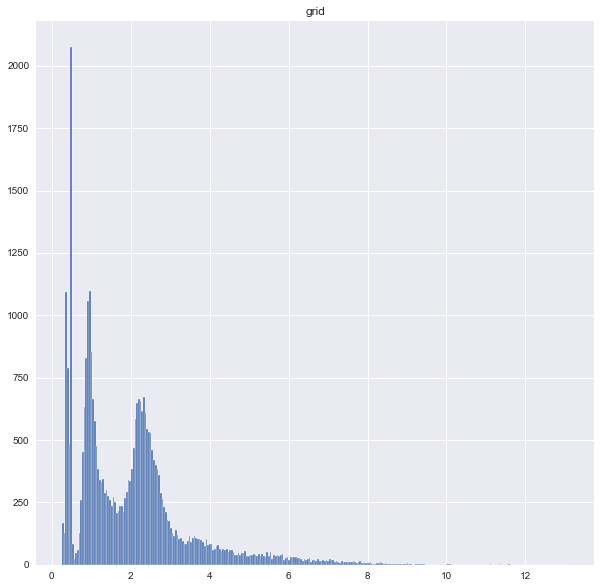

In [143]:
histograma = df_household.hist(xlabelsize=10, ylabelsize=10, bins=300, figsize=(10, 10))

**2. Gráfico de densidades**

Visualiza la distribución de los datos. Es una variable del histograma, pero elimina el ruido, por lo que son mejores para determinar la forma de distribución de un atributo. Lo spicos del gráfico de densidad ayudan a mostrar dónde los valores se concentran más. 

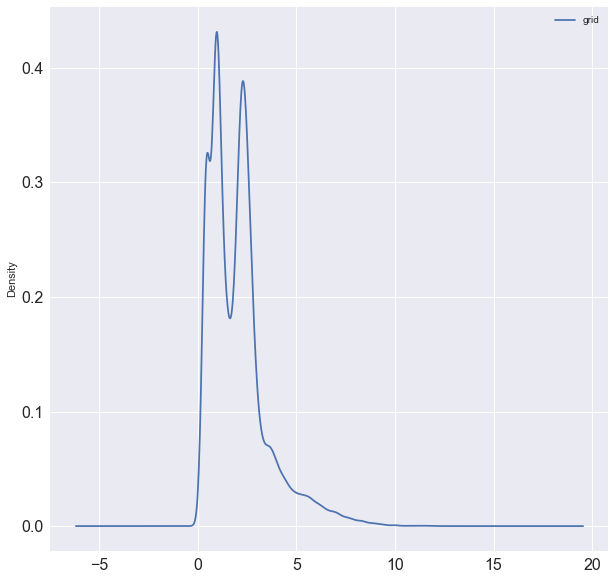

In [144]:
density = df_household.plot(kind='kde', legend=True, layout=(1, 1), figsize=(10, 10),
                        fontsize=16, stacked=True) 

**3. Boxplots** 

El boxplot (diagrama de caja) nos permite identificar los valores atípicos y comparar distribuciones. Además, se conoce como se distribuyen el 50% de los valores (dentro de la caja). 

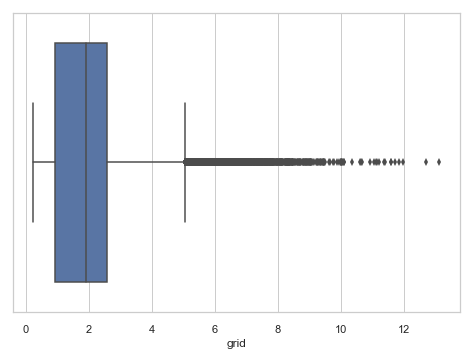

In [145]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=df_household["grid"])


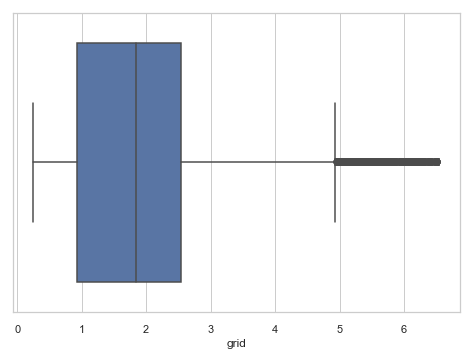

In [146]:
from scipy import stats

z_score = np.abs(stats.zscore(df_household))
threshold = 3
df_household_no_outliers = df_household[(z_score < threshold).all(axis=1)]
df_household_no_outliers.shape
ax = sns.boxplot(x=df_household_no_outliers["grid"])

## *4. Preparar los datos*

1. Limpieza y reestructuración de datos
2. Transformar


Transformo los datos para obtener la potencia media horaria. Cada fila representará 1h. 

In [147]:
df_household_hourly = df_household_no_outliers.resample('H').mean()
print(df_household_hourly)

                         grid
datetime                     
2018-01-17 00:00:00  1.284250
2018-01-17 01:00:00  1.264500
2018-01-17 02:00:00  1.333000
2018-01-17 03:00:00  1.182000
2018-01-17 04:00:00  1.169750
...                       ...
2018-12-31 19:00:00  2.653500
2018-12-31 20:00:00  2.674000
2018-12-31 21:00:00  3.439333
2018-12-31 22:00:00  2.036000
2018-12-31 23:00:00  1.120750

[8376 rows x 1 columns]


In [148]:
# creo una nueva columna con la hora
df_household_hourly['hour'] = df_household_hourly.index.hour
print(df_household_hourly)


                         grid  hour
datetime                           
2018-01-17 00:00:00  1.284250     0
2018-01-17 01:00:00  1.264500     1
2018-01-17 02:00:00  1.333000     2
2018-01-17 03:00:00  1.182000     3
2018-01-17 04:00:00  1.169750     4
...                       ...   ...
2018-12-31 19:00:00  2.653500    19
2018-12-31 20:00:00  2.674000    20
2018-12-31 21:00:00  3.439333    21
2018-12-31 22:00:00  2.036000    22
2018-12-31 23:00:00  1.120750    23

[8376 rows x 2 columns]


In [149]:
# El nuevo índice contiene ahora solo la fecha (DD/MM/YYYY)
df_household_hourly.index = df_household_hourly.index.date
df_household_hourly.head()

,grid,hour
2018-01-17,1.28425,0
2018-01-17,1.26450,1
2018-01-17,1.33300,2
2018-01-17,1.18200,3
2018-01-17,1.16975,4


In [150]:
# Creamos una columna con la potencia media horaria de cada hora 
df_household_pivot = df_household_hourly.pivot(columns='hour')
df_household_pivot = df_household_pivot.dropna()
df_household_pivot.head()

grid                                                        \
hour             0        1        2        3        4        5        6    
2018-01-17  1.28425  1.26450  1.33300  1.18200  1.16975  1.45550  1.34650   
2018-01-18  1.32600  1.21750  1.36875  1.13925  1.17775  1.43775  1.33775   
2018-01-19  1.21200  1.29750  1.10275  1.08825  1.12450  1.16650  1.11525   
2018-01-20  1.08925  1.08125  1.11825  1.05975  1.12675  1.08775  1.12525   
2018-01-21  0.90800  0.88075  1.03975  0.82750  1.02300  0.98700  1.07275   

                                       ...                             \
hour             7        8        9   ...       14       15       16   
2018-01-17  1.67500  3.33525  2.96650  ...  3.48850  3.47500  2.99525   
2018-01-18  1.34300  2.51750  2.68600  ...  2.69000  2.77850  2.70525   
2018-01-19  1.30150  1.68525  2.06150  ...  2.46725  2.25600  2.60200   
2018-01-20  1.09100  1.53600  2.18075  ...  2.21900  2.25625  2.18575   
2018-01-21  1.19575  1.49650  2.45325  ...  2.76200  2.90275  2.70900   

                                                                          
hour             17       18       19       20       21       22      23  
2018-01-17  2.63750  3.07300  2.92225  2.71925  2.81200  1.99375  1.3035  
2018-01-18  3.05175  2.99225  2.61175  2.59775  2.66325  1.26450  1.2275  
2018-01-19  2.38925  2.56550  2.71550  5.15050  2.66100  2.26025  1.1555  
2018-01-20  2.60575  2.54750  2.44475  2.48825  2.73000  1.18325  1.1970  
2018-01-21  2.76900  2.78775  2.67200  3.27650  2.76150  3.36600  2.1470  

[5 rows x 24 columns]

### Ploteamos los datos transformados
Cada línea muestra el consumo horario de un día del año. 

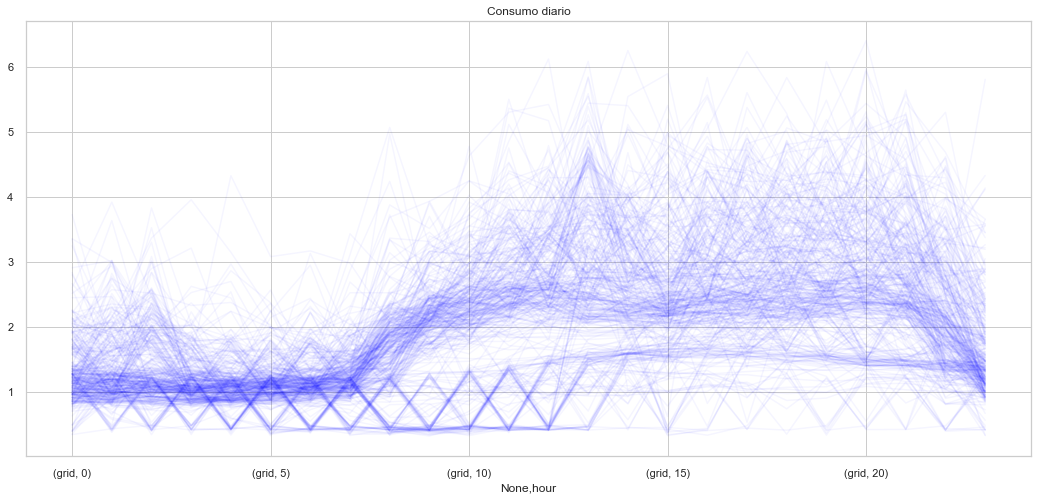

In [151]:
# Consumo horario. Transpuesta
df_household_pivot.T.plot(figsize=(18, 8), title='Consumo diario', legend=False, color='blue', alpha=0.04)



**2. Transformación**. 

Se escalan los datos utilizando el método de *MinMaxScaler()*

In [152]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = df_household_pivot.values.copy()
X_scale = pd.DataFrame(scaler.fit_transform(X))
X_scale.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.278402,0.250829,0.284435,0.232494,0.209138,0.410831,0.351616,0.434184,0.633900,0.733089,...,0.526832,0.565643,0.483872,0.381329,0.496659,0.450318,0.384439,0.458282,0.326218,0.178268
1,0.290737,0.237561,0.294683,0.220662,0.211143,0.404390,0.348500,0.327268,0.461124,0.655404,...,0.390038,0.440553,0.431174,0.452549,0.481941,0.396285,0.364130,0.429815,0.177603,0.164401
2,0.257054,0.260145,0.218432,0.206546,0.197794,0.305969,0.269255,0.313904,0.285284,0.482448,...,0.351878,0.346713,0.412411,0.338649,0.404162,0.414339,0.790815,0.429385,0.380528,0.151264
3,0.220786,0.199097,0.222875,0.198658,0.198358,0.277395,0.272816,0.246115,0.253750,0.515475,...,0.309349,0.346758,0.336771,0.375870,0.400881,0.367224,0.345828,0.442589,0.161045,0.158836
4,0.167233,0.142494,0.200373,0.134376,0.172349,0.240838,0.254118,0.279849,0.245405,0.590944,...,0.402373,0.462868,0.431855,0.403937,0.444669,0.406769,0.477581,0.448617,0.605869,0.332178


## 5. Construcción del modelo de aprendizaje NO supervisado: Data Clustering utilizando K-means

Se agrupan los datos utilizando el algoritmo [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) y la métrica de evaluación [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). El algoritmo K-means necesita que se le indique el número de clústers en que se quieren agrupar los datos. Se ejecuta el algoritmo para varios clusters y luego se comparan los resultados utilizando la métrica silhouette_score, que indicará el número óptimo de clusters.  

In [153]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Evalúo el algoritmo K-means para un rango de [2,15] clústers 
n_cluster_list = np.arange(2, 16).astype(int)


In [154]:
# Iteración para evaluar K-means para diferentes números de clusters (n_clusters)
for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    cluster_found = kmeans.fit_predict(X_scale)
    silhouette_scores.append(silhouette_score(X_scale, kmeans.labels_, random_state=0))


### Número óptimo de clusters: Silhouette Coefficient
Se utiliza el Silhouette Coefficient, donde el mejor valor es 1 y el peor valor es -1. Los valores cercanos a 0 indican cúmulos superpuestos. Los valores negativos generalmente indican que una muestra ha sido asignada al cúmulo equivocado, ya que un cúmulo diferente es más similar.[sklearn.metrics.silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

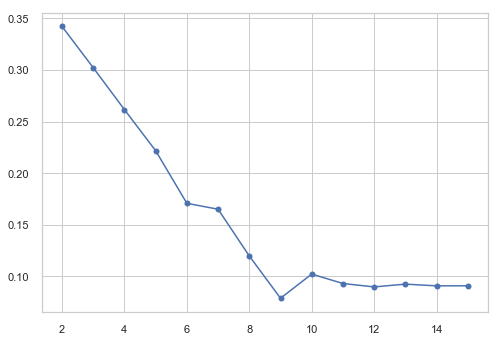

In [155]:
silhouette_metric = pd.DataFrame(index=n_cluster_list, columns=['silhouette_score'], data=silhouette_scores)
plt.plot(silhouette_metric, marker='o') 


In [156]:
# Entreno el K-means para k=2, visto el resultado del método Silhouette
kmeans = KMeans(n_clusters=2)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')

# Creo un multindex del tipo: (fecha,cluster al que pertenece el día)
df_household_pivot = df_household_pivot.set_index(cluster_found_sr, append=True)
df_household_pivot.index

MultiIndex([(2018-01-17, 0),
            (2018-01-18, 0),
            (2018-01-19, 0),
            (2018-01-20, 0),
            (2018-01-21, 0),
            (2018-01-22, 0),
            (2018-01-23, 0),
            (2018-01-24, 0),
            (2018-01-25, 0),
            (2018-01-26, 0),
            ...
            (2018-12-22, 0),
            (2018-12-23, 0),
            (2018-12-24, 0),
            (2018-12-25, 0),
            (2018-12-26, 0),
            (2018-12-27, 0),
            (2018-12-28, 0),
            (2018-12-29, 0),
            (2018-12-30, 0),
            (2018-12-31, 0)],
           names=[None, 'cluster'], length=348)

[0, 1]


Text(0.5, 0, 'Horas')

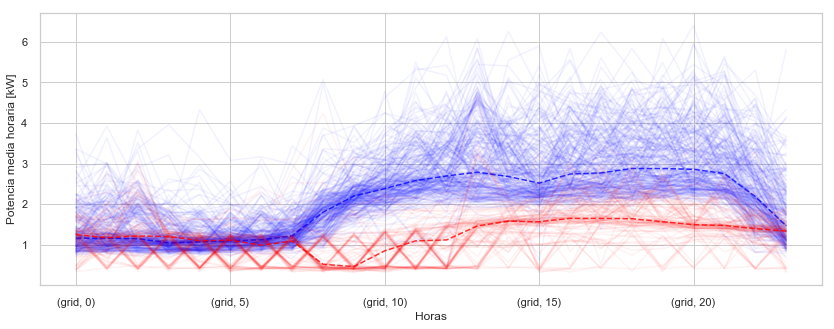

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(14,5))
color_list = ['blue',  'red']
cluster_values = sorted(df_household_pivot.index.get_level_values('cluster').unique())
print(cluster_values)

for cluster, color in zip(cluster_values, color_list):
    # ploteo todas las lineas de cada cluster
    df_household_pivot.xs(cluster, level=1).T.plot(ax=ax, legend=False, alpha=0.05, color=color)
    # ploteo la línea con el valor de la mediana de cada cluster
    df_household_pivot.xs(cluster, level=1).median().plot(ax=ax, color=color, legend=False, alpha=0.8, ls='--')

ax.set_ylabel('Potencia media horaria [kW]')
ax.set_xlabel('Horas')


K-means ha encontrado los los clúster con las siguientes características, mirando la gráfica anterior:
* El clúster de azul concentra los patrones de consumo más elevados y con más picos de consumo
* El clúster rojo concentra una menor potencia media horaria de consumo


## Validar los resultados con Dimensionality Reduction (PCA)
Principal Component Analysis (PCA) es un método estadístico que permite simplificar la complejidad de espacios muestrales con muchas dimensiones a la vez que conserva su información. Se reducen las "features" de 24 a 2. 
Una forma de validar los resultados del algoritmo clustering es mediante técnicas de dimensionality reduction. Hay que tener en cuenta es que el PCA no sabe nada de los grupos encontrados por K-means.

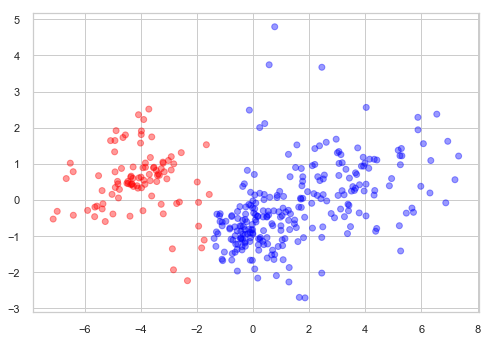

In [158]:
from sklearn.decomposition import PCA
import matplotlib.colors

pca = PCA(n_components=2)
results_pca = pca.fit_transform(X)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

plt.scatter(results_pca[:, 0], results_pca[:, 1],
            c=df_household_pivot.index.get_level_values('cluster'),
            cmap=cmap,
            alpha=0.4,
            )
plt.show()

En el gráfico anterior, cada punto representa un perfil diario de consumo. Se redujeron las dimensiones de 24 a tan solo 2. Teóricamente, la distancia entre los puntos del espacio dimensional se mantiene, por lo que los puntos que están cerca tienen perfiles de consumo diario similares. 

El hecho de que la mayoría de los puntos azules y rojos estén cerca, es una buena indicación de que la agrupación es correcta. Se utiliza el resultados del algoritmo K-means para colorear los puntos y poder así evaluar el comportamiento del algoritmo K-means. 
 

## EJERCICIO: Probar con el método Elbow y ver si da similar. Probar con diferentes clusters y plotear.
